In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# DIR = r'E:\Image Datasets\Horses_2_Zebras\Train'
# DIR = r'E:\Image Datasets\Traffic Signs\dataset\Train'
DIR = r'E:\Image Datasets\Potato Leaf Disease\PlantVillage'
image_size = 256
batch_size = 32
num_examples = 1000
patch_size = 32
channels = 3
d_model = 1024
dff = 2048
dropout_rate = 0.1
num_heads = 8
num_blocks = 8

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, image_size = (image_size, image_size), shuffle = True,
                                                              batch_size = batch_size)
class_names = dataset.class_names
class_names

Found 2152 files belonging to 3 classes.


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

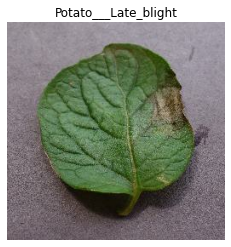

In [4]:
d = next(iter(dataset))
plt.imshow(d[0][0].numpy().astype('uint8'))
plt.title(class_names[d[1][0].numpy()])
plt.axis('off')
plt.show()

In [5]:
def split_data(data, rescale = 1.0/255):
    data_len = len(data) 
    
    train_images, train_labels = [], []
    val_images, val_labels = [], []
    test_images, test_labels = [], []
    
    train_data = data.take(int(data_len*0.8))
    val_data = data.skip(len(train_data))
    test_data = data.skip(len(train_data) + len(val_data))
    
    for i, dt in enumerate([train_data, val_data, test_data]):
        for imgs, lbls in dt:
            for k in range(imgs.shape[0]):
                if i == 0:
                    train_images.append(imgs[k])
                    train_labels.append(lbls[k])
                    
                elif i == 1:
                    val_images.append(imgs[k])
                    val_labels.append(lbls[k])
                    
                else:
                    test_images.append(imgs[k])
                    test_labels.append(lbls[k])
                    
    train_images, train_labels = np.array(train_images) * rescale, np.array(train_labels)
    val_images, val_labels = np.array(val_images) * rescale, np.array(val_labels)
    test_images, test_labels = np.array(test_images) * rescale, np.array(test_labels)
    
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

In [6]:
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = split_data(dataset)

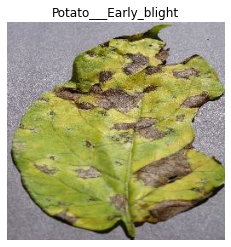

In [7]:
plt.imshow(train_images[0])
plt.title(class_names[train_labels[0]])
plt.axis('off')
plt.show()

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))\
.shuffle(num_examples).batch(batch_size, drop_remainder = True)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))\
.shuffle(num_examples).batch(batch_size, drop_remainder = True)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))\
.shuffle(num_examples).batch(batch_size, drop_remainder = True)

In [9]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads
        
        assert d_model%num_heads == 0
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.wo = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, h):
        x = tf.reshape(h, (h.shape[0], -1, self.num_heads, self.depth))
        return tf.transpose(x, perm = [0, 2, 1, 3])
        
    def self_attention(self, q, k, v):
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        
        score = tf.matmul(q, k, transpose_b = True) * tf.math.rsqrt(dk)
        attention_weights = tf.nn.softmax(score, axis = -1)
        out = tf.matmul(attention_weights, v)
        return out, attention_weights
        
    def call(self, x):
        q = self.split_heads(self.wq(x))
        k = self.split_heads(self.wk(x))
        v = self.split_heads(self.wv(x))
        
        out, attention_weights = self.self_attention(q, k, v)
        out = tf.concat([out[:, i, :, :] for i in range(self.num_heads)], axis = -1)
        out = self.wo(out)
        return out, attention_weights

In [10]:
class MultiLayerPerceptron(tf.keras.layers.Layer):
    def __init__(self, dff, d_model, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.linear_1 = tf.keras.layers.Dense(dff, activation = 'gelu')
        self.dropout_1 = tf.keras.layers.Dropout(dropout_rate)
        self.linear_2 = tf.keras.layers.Dense(d_model)
        self.dropout_2 = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, x):
        return self.dropout_2(self.linear_2(self.dropout_1(self.linear_1(x))))

In [11]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, dff, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.layernorm_1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.mha = MultiHeadAttention(num_heads, d_model)
        self.dropout_1 = tf.keras.layers.Dropout(dropout_rate)
        
        self.layernorm_2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.mlp = MultiLayerPerceptron(dff, d_model, dropout_rate)
        self.dropout_2 = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, x, training):
        
        x1 = self.layernorm_1(x)
        x1, _ = self.mha(x1)
        x1 = self.dropout_1(x1, training = training)
        x1 += x
        
        x2 = self.layernorm_2(x1)
        x2 = self.mlp(x2)
        x2 = self.dropout_2(x2, training = training)
        x2 += x1

        return x2

In [19]:
class VisionTransformer(tf.keras.models.Model):
    def __init__(self, num_classes, image_size, patch_size, channels, num_heads, d_model, dff, dropout_rate, 
                 num_blocks, **kwargs):
        super().__init__(**kwargs)
        self.image_size = image_size
        self.patch_size = patch_size
        self.d_model = d_model
        self.channels = channels
        self.num_patches = (image_size // patch_size) ** 2
        
        self.rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
        self.linear_projection = tf.keras.layers.Dense(d_model)
        
        self.pos_emb = self.add_weight('pos_emb', shape = (1, self.num_patches + 1, d_model))
        self.class_emb = self.add_weight('class_emb', shape = (1, 1, d_model))
        
        self.transformer_blocks = [TransformerBlock(num_heads, d_model, dff, dropout_rate) for _ in range(num_blocks)]
        
        self.layernorm_1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.linear_1 = tf.keras.layers.Dense(dff, activation = 'gelu')
        self.dropout_1 = tf.keras.layers.Dropout(dropout_rate)
        self.final_layer = tf.keras.layers.Dense(num_classes)
        
#     def build(self, input_shape):
#         batch_size = input_shape[0]
#         self.channels = input_shape[-1]
        
#         self.class_emb = self.add_weight(shape = (batch_size, 1, self.d_model))
#         self.pos_emb = self.add_weight('pos_emb', shape = (1, self.num_patches+1, self.d_model))
        
    def extract_patches(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(images, sizes = [1, self.patch_size, self.patch_size, 1], 
                                           strides = [1, self.patch_size, self.patch_size, 1], rates = [1, 1, 1, 1], 
                                           padding = 'VALID')
        return tf.reshape(patches, (batch_size, self.num_patches, (self.patch_size**2)*self.channels))
    
    def classification_head(self, x):
        return self.final_layer(self.dropout_1(self.linear_1(self.layernorm_1(x))))
        
    def call(self, x, training):
        batch_size = tf.shape(x)[0]
        x = self.rescale(x)
        out = self.extract_patches(x)
        out = self.linear_projection(out)
        
        class_emb = tf.broadcast_to(self.class_emb, [batch_size, 1, self.d_model])
        
        out = tf.concat([class_emb, out], axis = 1)
        out += self.pos_emb
        
        for blocks in self.transformer_blocks:
            out = blocks(out, training)
            
        out = self.classification_head(out[:, 0])
        return out

In [20]:
vit = VisionTransformer(len(class_names), image_size, patch_size, channels, num_heads, d_model, dff, dropout_rate, 
                        num_blocks)

In [21]:
loss_function = lambda real, pred: tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)(real, pred)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)

def get_accuracy(real, pred):
    pred = tf.argmax(tf.nn.softmax(pred, axis = 1), axis = 1)
    out = tf.math.reduce_mean(tf.abs(tf.cast(real, tf.float32) - tf.cast(pred, tf.float32)))
    return out

In [22]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        preds = vit(images, training = True)
        loss = loss_function(labels, preds)
        acc = get_accuracy(labels, preds)
        
    batch_loss = loss/batch_size
    
    grads = tape.gradient(loss, vit.trainable_variables)
    optimizer.apply_gradients(zip(grads, vit.trainable_variables))
    return batch_loss, acc

In [23]:
EPOCHS = 100
losses = []
accuracies = []

for e in range(EPOCHS):
    loss = 0
    acc = 0
    print(f'Epochs: {e} Starts.')
    for batch, (img, lbl) in enumerate(train_dataset):
        batch_loss, batch_acc = train_step(img, lbl)
        loss += batch_loss
        acc += batch_acc
        
        losses.append(batch_loss)
        accuracies.append(batch_acc)
        if batch%10 == 0:
            print(f'Batch: {batch} \t Loss: {batch_loss} \t Accuracy: {batch_acc}')
        
    loss/=len(train_dataset)
    acc/=len(train_dataset)
    losses.append(loss)
    accuracies.append(acc)
    print(f'Epoch: {e} \t Loss: {loss} \t Accuracy: {acc}\n\n\n')

Epochs: 0 Starts.
Batch: 0 	 Loss: 0.03502081707119942 	 Accuracy: 0.6875
Batch: 10 	 Loss: 0.04356950893998146 	 Accuracy: 0.4375
Batch: 20 	 Loss: 0.033297616988420486 	 Accuracy: 0.5625
Batch: 30 	 Loss: 0.027951227501034737 	 Accuracy: 0.4375
Batch: 40 	 Loss: 0.022283408790826797 	 Accuracy: 0.25
Batch: 50 	 Loss: 0.03708796203136444 	 Accuracy: 0.53125
Epoch: 0 	 Loss: 0.051905062049627304 	 Accuracy: 0.5734953880310059



Epochs: 1 Starts.
Batch: 0 	 Loss: 0.033715084195137024 	 Accuracy: 0.75
Batch: 10 	 Loss: 0.02992728352546692 	 Accuracy: 0.53125
Batch: 20 	 Loss: 0.02883218601346016 	 Accuracy: 0.5
Batch: 30 	 Loss: 0.027056589722633362 	 Accuracy: 0.4375
Batch: 40 	 Loss: 0.026168454438447952 	 Accuracy: 0.28125
Batch: 50 	 Loss: 0.03093479387462139 	 Accuracy: 0.6875
Epoch: 1 	 Loss: 0.030165210366249084 	 Accuracy: 0.5601851940155029



Epochs: 2 Starts.
Batch: 0 	 Loss: 0.028447847813367844 	 Accuracy: 0.46875
Batch: 10 	 Loss: 0.028639666736125946 	 Accuracy: 0.59375
B

KeyboardInterrupt: 

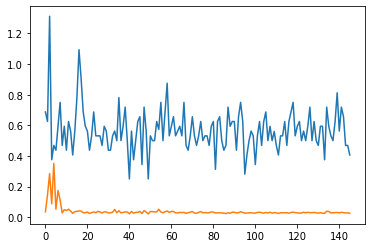

In [24]:
plt.plot(accuracies)
plt.plot(losses)
plt.show()